In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys
import glob

# Precinct Shapefile
---
## VEST's Documentation File

Election results from the New Mexico Secretary of State's website (http://electionresults.sos.state.nm.us/).
Precinct shapefiles for most counties from the state legislature's redistricting site (https://www.nmlegis.gov/Redistricting/). Lincoln, Los Alamos, McKinley, Sandoval, and Socorro updated with VTDs released by the Census Bureau's Redistricting Data Program.

Two additional precincts added to Santa Fe's 2011 map based on a 2016 PDF.
Several precincts in Roosevelt County renumbered from the 2011 map.

* G16PRERTRU - Donald J. Trump (Republican Party)
* G16PREDCLI - Hillary Clinton (Democratic Party)
* G16PRELJOH - Gary Johnson (Libertarian Party)
* G16PREGSTE - Jill Stein (Green Party)
* G16PREIMCM - Evan McMullin (Better For America Party)
* G16PRECCAS - Darrell L. Castle (Constitution Party)
* G16PRESLAR - Gloria La Riva (Socialism and Liberation Party)
* G16PREAROC - Roque De La Fuente (American Delta Party)


* G16SOSRESP - Nora Espinoza (Republican Party)
* G16SOSDOLI - Maggie Toulouse Oliver (Democratic Party)


* G16SSCRNAK - Judith K. Nakamura (Republican Party)
* G16SSCDVIG - Michael E. Vigil (Democratic Party)


* G16SACRFRE - Stephen G. French (Republican Party)
* G16SACDVAR - Julie J. Vargas (Democratic Party)

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nm_2016/nm_2016.shp")

In [3]:
vest_shp.shape

(1492, 18)

In [4]:
vest_shp.head(1)

,COUNTYFP,VTDST,NAMELSAD,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,geometry
0,003,6,Catron County Precinct 6,79,20,7,2,1,1,0,0,80,31,84,26,86,23,"POLYGON Z ((-108.71685 33.98629 0.00000, -108...."


In [5]:
vest_shp.to_csv("./check.csv")

<AxesSubplot:>

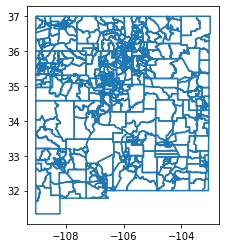

In [6]:
vest_shp.boundary.plot()

In [7]:
vest_shp.columns

Index(['COUNTYFP', 'VTDST', 'NAMELSAD', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREIMCM', 'G16PRECCAS', 'G16PRESLAR',
       'G16PREAROC', 'G16SOSRESP', 'G16SOSDOLI', 'G16SSCRNAK', 'G16SSCDVIG',
       'G16SACRFRE', 'G16SACDVAR', 'geometry'],
      dtype='object')

## Loading, Combining Election Results
The SOS directed to this link for election results for the 2016 general: (http://electionresults.sos.state.nm.us/) 
The updated link for 2016 general election results: (https://electionresults.sos.state.nm.us/?eid=84)

In [8]:
folder = os.listdir("./raw-from-source/Election_Results/")

files = []
for file in folder:
    if "Precinct" in file:
        election = pd.ExcelFile("./raw-from-source/Election_Results/" + file)
        counties = election.sheet_names
        df_election = []
        for county in counties: 
            df = pd.read_excel(election, sheet_name = county, skiprows=[0,1,2,3,4,5])
            df = df.loc[:, df.columns != df.columns[0]]
            df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
            df_election.append(df)
        combined_df_election = pd.concat(df_election)
        combined_df_election.reset_index(drop=True,inplace=True)
        files.append(combined_df_election)
nm_16 = pd.concat(files, axis = 1)

nm_16 = nm_16.rename(columns = {'GARY JOHNSON AND BILL WELD':'G16PRELJOH',
       'DARRELL CASTLE AND SCOTT BRADLEY':'G16PRECCAS',
       'DONALD J TRUMP AND MICHAEL R PENCE':'G16PRERTRU',
       'HILLARY RODHAM CLINTON AND TIMOTHY MICHAEL KAINE':'G16PREDCLI',
       'JILL STEIN AND AJAMU BARAKA':'G16PREGSTE', 'GLORIA LA RIVA AND DENNIS BANKS':'G16PRESLAR',
       'EVAN MCMULLIN AND NATHAN JOHNSON':'G16PREIMCM',
       '"ROCKY" ROQUE DE LA FUENTE AND MICHAEL STEINBERG':'G16PREAROC', 'STEPHEN G FRENCH':'G16SACRFRE',
       'JULIE J VARGAS':'G16SACDVAR', 'NORA ESPINOZA':'G16SOSRESP', 'MAGGIE TOULOUSE OLIVER':'G16SOSDOLI',
       'JUDITH K NAKAMURA':'G16SSCRNAK', 'MICHAEL E VIGIL':'G16SSCDVIG'})

nm_16 = nm_16[['County','Precinct','G16PRERTRU','G16PREDCLI','G16PRELJOH','G16PREGSTE','G16PREIMCM',
               'G16PRECCAS','G16PRESLAR','G16PREAROC','G16SOSRESP','G16SOSDOLI','G16SSCRNAK','G16SSCDVIG',
               'G16SACRFRE','G16SACDVAR']]

nm_16 = nm_16.loc[:,~nm_16.columns.duplicated()]

nm_16 = nm_16[nm_16["Precinct"]!="TOTALS"]

# Fill n/a values with 0
nm_16 = nm_16.fillna(0)
nm_16 = nm_16.replace(to_replace="*", value = 0)

# Display results in alphabetical order of the counties
nm_16 = nm_16.sort_values(by = ['County', 'Precinct'], ascending = True)

# Deal with the index 
nm_16.reset_index(drop=True,inplace=True)

nm_16.to_csv("./nm_16.csv")
nm_16


,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR
0,Bernalillo,PCT 001,311,346,61,9,6,0,0,0,299,389,391,302,348,336
1,Bernalillo,PCT 002,270,288,52,0,11,0,0,0,275,330,387,215,329,259
2,Bernalillo,PCT 003,352,381,86,20,9,0,0,0,363,451,492,328,428,384
3,Bernalillo,PCT 004,202,290,66,7,7,0,0,0,219,342,337,216,296,250
4,Bernalillo,PCT 005,183,302,35,0,0,0,0,0,173,338,287,222,224,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,Valencia,PRECINCT 37,187,135,32,0,0,0,0,0,177,176,203,145,188,154
1488,Valencia,PRECINCT 38,306,221,59,0,0,0,0,0,302,277,349,227,321,253
1489,Valencia,PRECINCT 39,652,518,106,11,13,0,0,0,659,613,751,514,689,569
1490,Valencia,PRECINCT 40,387,335,82,7,6,0,0,0,371,437,447,354,403,390


In [9]:
# Change strings to integers (County and Precinct columns remain unchanged)
nm_16 = nm_16.apply(pd.to_numeric, errors='ignore')

## Validating Election Results

### Check Statewide Candidate Totals

In [10]:
data_columns = ['G16PRERTRU','G16PREDCLI','G16PRELJOH','G16PREGSTE','G16PREIMCM',
               'G16PRECCAS','G16PRESLAR','G16PREAROC','G16SOSRESP','G16SOSDOLI','G16SSCRNAK','G16SSCDVIG',
               'G16SACRFRE','G16SACDVAR']
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [11]:
statewide_totals_check(vest_shp,nm_16,data_columns)

***Statewide Totals Check***
G16PRERTRU has a difference of 29 votes
	VEST: 319667 votes
	SOURCES: 319638 votes
G16PREDCLI has a difference of 71 votes
	VEST: 385234 votes
	SOURCES: 385163 votes
G16PRELJOH has a difference of 139 votes
	VEST: 74541 votes
	SOURCES: 74402 votes
G16PREGSTE has a difference of 1848 votes
	VEST: 9879 votes
	SOURCES: 8031 votes
G16PREIMCM has a difference of 1988 votes
	VEST: 5825 votes
	SOURCES: 3837 votes
G16PRECCAS has a difference of 1355 votes
	VEST: 1514 votes
	SOURCES: 159 votes
G16PRESLAR has a difference of 1099 votes
	VEST: 1184 votes
	SOURCES: 85 votes
G16PREAROC has a difference of 475 votes
	VEST: 475 votes
	SOURCES: 0 votes
G16SOSRESP has a difference of -31031 votes
	VEST: 334733 votes
	SOURCES: 365764 votes
G16SOSDOLI has a difference of -19349 votes
	VEST: 433227 votes
	SOURCES: 452576 votes
G16SSCRNAK has a difference of -3520 votes
	VEST: 396303 votes
	SOURCES: 399823 votes
G16SSCDVIG has a difference of -3223 votes
	VEST: 365790 votes
	SO

### Check County Totals

#### County FIPs Data 

In [12]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Mexico"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
NM_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"McKinley":"Mckinley"}
nm_16["COUNTYFP"] = nm_16["County"].map(county_name_changes_dict).fillna(nm_16["County"])

# Use the dictionary to go from a county name to a county FIPS
nm_16["COUNTYFP"] = nm_16["COUNTYFP"].map(NM_fips_dict).fillna(nm_16["COUNTYFP"])

# Check the number of counties - looking for 33
print(len(nm_16["COUNTYFP"].unique()))

33


In [13]:
# print(fips_file["FIPS County"])

In [14]:
# print(fips_file["County Name"])

In [15]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [16]:
county_totals_check(vest_shp,nm_16,data_columns,"COUNTYFP", full_print=False)

***Countywide Totals Check***

G16PRERTRU contains differences in these counties:
	006 has a difference of 5 votes
		VEST: 3195 votes
		SOURCES: 3190 votes
	039 has a difference of 5 votes
		VEST: 3599 votes
		SOURCES: 3594 votes
	049 has a difference of 3 votes
		VEST: 14332 votes
		SOURCES: 14329 votes
	053 has a difference of 8 votes
		VEST: 2616 votes
		SOURCES: 2608 votes
	055 has a difference of 8 votes
		VEST: 2727 votes
		SOURCES: 2719 votes
G16PREDCLI contains differences in these counties:
	005 has a difference of 4 votes
		VEST: 5534 votes
		SOURCES: 5530 votes
	009 has a difference of 7 votes
		VEST: 3121 votes
		SOURCES: 3114 votes
	015 has a difference of 8 votes
		VEST: 5033 votes
		SOURCES: 5025 votes
	017 has a difference of 5 votes
		VEST: 6276 votes
		SOURCES: 6271 votes
	025 has a difference of 2 votes
		VEST: 3930 votes
		SOURCES: 3928 votes
	035 has a difference of 11 votes
		VEST: 6124 votes
		SOURCES: 6113 votes
	037 has a difference of 6 votes
		VEST: 1017 vote

		VEST: 29 votes
		SOURCES: 0 votes
	029 has a difference of 13 votes
		VEST: 13 votes
		SOURCES: 0 votes
	031 has a difference of 52 votes
		VEST: 58 votes
		SOURCES: 6 votes
	033 has a difference of 4 votes
		VEST: 4 votes
		SOURCES: 0 votes
	035 has a difference of 60 votes
		VEST: 67 votes
		SOURCES: 7 votes
	037 has a difference of 8 votes
		VEST: 8 votes
		SOURCES: 0 votes
	039 has a difference of 17 votes
		VEST: 17 votes
		SOURCES: 0 votes
	041 has a difference of 11 votes
		VEST: 11 votes
		SOURCES: 0 votes
	043 has a difference of 105 votes
		VEST: 129 votes
		SOURCES: 24 votes
	045 has a difference of 113 votes
		VEST: 125 votes
		SOURCES: 12 votes
	047 has a difference of 19 votes
		VEST: 25 votes
		SOURCES: 6 votes
	049 has a difference of 68 votes
		VEST: 75 votes
		SOURCES: 7 votes
	051 has a difference of 12 votes
		VEST: 12 votes
		SOURCES: 0 votes
	053 has a difference of 15 votes
		VEST: 15 votes
		SOURCES: 0 votes
	055 has a difference of 6 votes
		VEST: 6 votes
		S

		VEST: 2833 votes
		SOURCES: 2825 votes
G16SACDVAR contains differences in these counties:
	005 has a difference of 2 votes
		VEST: 6274 votes
		SOURCES: 6272 votes
	006 has a difference of -4475 votes
		VEST: 4482 votes
		SOURCES: 8957 votes
	007 has a difference of -5939 votes
		VEST: 2423 votes
		SOURCES: 8362 votes
	009 has a difference of 5 votes
		VEST: 3820 votes
		SOURCES: 3815 votes
	015 has a difference of -4731 votes
		VEST: 5908 votes
		SOURCES: 10639 votes
	021 has a difference of 34 votes
		VEST: 182 votes
		SOURCES: 148 votes
	025 has a difference of 3 votes
		VEST: 4485 votes
		SOURCES: 4482 votes
	029 has a difference of 1914 votes
		VEST: 3260 votes
		SOURCES: 1346 votes
	035 has a difference of 9 votes
		VEST: 6782 votes
		SOURCES: 6773 votes
	037 has a difference of 7 votes
		VEST: 1336 votes
		SOURCES: 1329 votes
	039 has a difference of 10 votes
		VEST: 10319 votes
		SOURCES: 10309 votes
	053 has a difference of 12 votes
		VEST: 3562 votes
		SOURCES: 3550 votes


## Precinct-Level Checks 

In [17]:
nm_16['Precinct'] = nm_16["Precinct"].str.zfill(3)
nm_16['Precinct'] = nm_16.Precinct.replace({'PCT':'Precinct', 'PREC ':'Precinct '}, regex = True)

nm_16

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,COUNTYFP
0,Bernalillo,Precinct 001,311,346,61,9,6,0,0,0,299,389,391,302,348,336,001
1,Bernalillo,Precinct 002,270,288,52,0,11,0,0,0,275,330,387,215,329,259,001
2,Bernalillo,Precinct 003,352,381,86,20,9,0,0,0,363,451,492,328,428,384,001
3,Bernalillo,Precinct 004,202,290,66,7,7,0,0,0,219,342,337,216,296,250,001
4,Bernalillo,Precinct 005,183,302,35,0,0,0,0,0,173,338,287,222,224,276,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,Valencia,PRECINCT 37,187,135,32,0,0,0,0,0,177,176,203,145,188,154,061
1488,Valencia,PRECINCT 38,306,221,59,0,0,0,0,0,302,277,349,227,321,253,061
1489,Valencia,PRECINCT 39,652,518,106,11,13,0,0,0,659,613,751,514,689,569,061
1490,Valencia,PRECINCT 40,387,335,82,7,6,0,0,0,371,437,447,354,403,390,061


In [18]:
add_digit_counties = ['De Baca', 'Eddy', 'Guadalupe', 'Hidalgo', 'Los Alamos', 'McKinley', 'Otero', 'San Juan', 'Valencia']
new_df = nm_16[nm_16['County'].isin(add_digit_counties)]
new_df['Precinct'] = new_df['Precinct'].str[9:]
new_df['Precinct'] = new_df['Precinct'].str.zfill(3)
new_df['Precinct'] = 'Precinct ' + new_df['Precinct'].astype(str)
new_df

i = nm_16[nm_16['County'].isin(add_digit_counties)].index
nm_16 = nm_16.drop(i)
nm_16 = pd.concat([nm_16, new_df], ignore_index = True)

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [19]:
number_precinct_check = nm_16[nm_16["County"]=="Colfax"]
number_precinct_check['Precinct'] = 'Precinct ' + number_precinct_check['Precinct'].astype(str)
number_precinct_check

j = nm_16[(nm_16.County == 'Colfax')].index
nm_16 = nm_16.drop(j)
nm_16 = pd.concat([nm_16, number_precinct_check], ignore_index = True)

# Display results in alphabetical order of the counties
nm_16 = nm_16.sort_values(by = ['County', 'Precinct'], ascending = True)

# Deal with the index 
nm_16.reset_index(drop=True,inplace=True)

# nm_16.to_csv("./new.csv")
nm_16

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,COUNTYFP
0,Bernalillo,Precinct 001,311,346,61,9,6,0,0,0,299,389,391,302,348,336,001
1,Bernalillo,Precinct 002,270,288,52,0,11,0,0,0,275,330,387,215,329,259,001
2,Bernalillo,Precinct 003,352,381,86,20,9,0,0,0,363,451,492,328,428,384,001
3,Bernalillo,Precinct 004,202,290,66,7,7,0,0,0,219,342,337,216,296,250,001
4,Bernalillo,Precinct 005,183,302,35,0,0,0,0,0,173,338,287,222,224,276,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,Valencia,Precinct 037,187,135,32,0,0,0,0,0,177,176,203,145,188,154,061
1488,Valencia,Precinct 038,306,221,59,0,0,0,0,0,302,277,349,227,321,253,061
1489,Valencia,Precinct 039,652,518,106,11,13,0,0,0,659,613,751,514,689,569,061
1490,Valencia,Precinct 040,387,335,82,7,6,0,0,0,371,437,447,354,403,390,061


In [20]:
nm_16.to_csv("./new.csv")

In [22]:
vest_shp['One_Time_ID'] = vest_shp["COUNTYFP"]+"-"+vest_shp['NAMELSAD']
vest_shp['Number'] = vest_shp['NAMELSAD'].str.extract('(\d+\.?\d*)', expand = True)
vest_shp['Number'] = vest_shp['Number'].str.zfill(3)
vest_shp

,COUNTYFP,VTDST,NAMELSAD,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,geometry,One_Time_ID,Number
0,003,6,Catron County Precinct 6,79,20,7,2,1,1,0,0,80,31,84,26,86,23,"POLYGON Z ((-108.71685 33.98629 0.00000, -108....",003-Catron County Precinct 6,006
1,003,3,Catron County Precinct 3,185,90,17,3,1,1,0,0,161,121,177,103,173,101,"POLYGON Z ((-108.49647 33.42450 0.00000, -108....",003-Catron County Precinct 3,003
2,003,4,Catron County Precinct 4,163,43,6,0,1,0,0,0,146,59,147,46,142,53,"POLYGON Z ((-108.69199 33.99020 0.00000, -108....",003-Catron County Precinct 4,004
3,003,2,Catron County Precinct 2,339,74,22,6,3,3,0,0,322,103,324,95,321,94,"POLYGON Z ((-109.04684 34.13613 0.00000, -109....",003-Catron County Precinct 2,002
4,003,1,Catron County Precinct 1,262,76,28,4,3,0,0,0,222,117,225,112,221,105,"POLYGON Z ((-108.00062 33.42893 0.00000, -108....",003-Catron County Precinct 1,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,043,74,Sandoval County Precinct 74,725,603,131,13,13,4,1,0,768,683,945,502,825,589,"POLYGON Z ((-106.58753 35.30346 0.00000, -106....",043-Sandoval County Precinct 74,074
1488,043,81,Sandoval County Precinct 81,319,269,82,4,11,2,1,0,351,322,417,252,373,279,"POLYGON Z ((-106.68445 35.24178 0.00000, -106....",043-Sandoval County Precinct 81,081
1489,043,76,Sanodval County Precinct 76,370,542,69,12,12,1,0,1,404,587,573,413,477,497,"POLYGON Z ((-106.50939 35.33444 0.00000, -106....",043-Sanodval County Precinct 76,076
1490,049,90,Santa Fe County Precinct 90,393,1144,93,31,5,0,0,0,439,1185,542,1051,558,1016,"POLYGON Z ((-106.00087 35.70845 0.00000, -106....",049-Santa Fe County Precinct 90,090


In [23]:
# vest_shp['NAMELSAD'] = vest_shp['NAMELSAD'].map(lambda x: str(x)[:-2])
vest_shp['NAMELSAD'] = vest_shp['NAMELSAD'].str.split('Precinct').str[0]

vest_shp

,COUNTYFP,VTDST,NAMELSAD,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,geometry,One_Time_ID,Number
0,003,6,Catron County,79,20,7,2,1,1,0,0,80,31,84,26,86,23,"POLYGON Z ((-108.71685 33.98629 0.00000, -108....",003-Catron County Precinct 6,006
1,003,3,Catron County,185,90,17,3,1,1,0,0,161,121,177,103,173,101,"POLYGON Z ((-108.49647 33.42450 0.00000, -108....",003-Catron County Precinct 3,003
2,003,4,Catron County,163,43,6,0,1,0,0,0,146,59,147,46,142,53,"POLYGON Z ((-108.69199 33.99020 0.00000, -108....",003-Catron County Precinct 4,004
3,003,2,Catron County,339,74,22,6,3,3,0,0,322,103,324,95,321,94,"POLYGON Z ((-109.04684 34.13613 0.00000, -109....",003-Catron County Precinct 2,002
4,003,1,Catron County,262,76,28,4,3,0,0,0,222,117,225,112,221,105,"POLYGON Z ((-108.00062 33.42893 0.00000, -108....",003-Catron County Precinct 1,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,043,74,Sandoval County,725,603,131,13,13,4,1,0,768,683,945,502,825,589,"POLYGON Z ((-106.58753 35.30346 0.00000, -106....",043-Sandoval County Precinct 74,074
1488,043,81,Sandoval County,319,269,82,4,11,2,1,0,351,322,417,252,373,279,"POLYGON Z ((-106.68445 35.24178 0.00000, -106....",043-Sandoval County Precinct 81,081
1489,043,76,Sanodval County,370,542,69,12,12,1,0,1,404,587,573,413,477,497,"POLYGON Z ((-106.50939 35.33444 0.00000, -106....",043-Sanodval County Precinct 76,076
1490,049,90,Santa Fe County,393,1144,93,31,5,0,0,0,439,1185,542,1051,558,1016,"POLYGON Z ((-106.00087 35.70845 0.00000, -106....",049-Santa Fe County Precinct 90,090


In [24]:
vest_shp['NAMELSAD'] = vest_shp['NAMELSAD']+'Precinct '+vest_shp['Number']

vest_shp = vest_shp.drop(columns = ['One_Time_ID','Number'])

# Display results in alphabetical order of the counties
vest_shp = vest_shp.sort_values(by = ['COUNTYFP', 'NAMELSAD'], ascending = True)

vest_shp.columns = vest_shp.columns.str.replace(' ', '')
vest_shp.columns = vest_shp.columns.str.rstrip()

# Deal with the index 
vest_shp.reset_index(drop=True,inplace=True)

vest_shp

,COUNTYFP,VTDST,NAMELSAD,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,geometry
0,001,1,Bernalillo County Precinct 001,311,346,61,9,6,0,0,0,299,389,391,302,348,336,"POLYGON Z ((-106.73042 35.21808 0.00000, -106...."
1,001,2,Bernalillo County Precinct 002,270,288,52,3,11,0,0,0,275,330,387,215,329,259,"POLYGON Z ((-106.66257 35.21786 0.00000, -106...."
2,001,3,Bernalillo County Precinct 003,352,381,86,20,9,0,1,0,363,451,492,328,428,384,"POLYGON Z ((-106.65818 35.21742 0.00000, -106...."
3,001,4,Bernalillo County Precinct 004,202,290,66,7,7,0,0,0,219,342,337,216,296,250,"POLYGON Z ((-106.64074 35.15617 0.00000, -106...."
4,001,5,Bernalillo County Precinct 005,183,302,35,3,3,1,0,0,173,338,287,222,224,276,"POLYGON Z ((-106.63341 35.17373 0.00000, -106...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,061,37,Valencia County Precinct 037,187,135,32,0,3,1,0,0,177,176,203,145,188,154,"POLYGON Z ((-106.76433 34.79094 0.00000, -106...."
1488,061,38,Valencia County Precinct 038,306,221,59,4,3,1,1,0,302,277,349,227,321,253,"POLYGON Z ((-106.65167 34.74108 0.00000, -106...."
1489,061,39,Valencia County Precinct 039,652,518,106,11,13,3,1,0,659,613,751,514,689,569,"POLYGON Z ((-106.79220 34.82029 0.00000, -106...."
1490,061,40,Valencia County Precinct 040,387,335,82,7,6,0,2,0,371,437,447,354,403,390,"POLYGON Z ((-106.72855 34.82258 0.00000, -106...."


In [25]:
# Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP"]+"-"+vest_shp['NAMELSAD']
# Check to make sure it is unique
print(vest_shp["join_col"].value_counts(dropna=False))

# Create an election results join col
nm_16["join_col"] = nm_16["COUNTYFP"]+"-"+nm_16["County"]+" County "+nm_16["Precinct"]
# Check to make sure it is unique
print(nm_16["join_col"].value_counts(dropna=False))

001-Bernalillo County Precinct 001    1
035-Otero County Precinct 030         1
035-Otero County Precinct 039         1
035-Otero County Precinct 038         1
035-Otero County Precinct 037         1
                                     ..
005-Chaves County Precinct 091        1
005-Chaves County Precinct 090        1
005-Chaves County Precinct 085        1
005-Chaves County Precinct 084        1
061-Valencia County Precinct 041      1
Name: join_col, Length: 1492, dtype: int64
001-Bernalillo County Precinct 001    1
035-Otero County Precinct 030         1
035-Otero County Precinct 039         1
035-Otero County Precinct 038         1
035-Otero County Precinct 037         1
                                     ..
005-Chaves County PRECINCT 091        1
005-Chaves County PRECINCT 090        1
005-Chaves County PRECINCT 085        1
005-Chaves County PRECINCT 084        1
061-Valencia County Precinct 041      1
Name: join_col, Length: 1492, dtype: int64


In [26]:
# Make sure the join_col in both files is unique
print(len(nm_16["join_col"]))
print(nm_16["join_col"].value_counts().sum())

print(len(vest_shp["join_col"]))
print(vest_shp["join_col"].value_counts().sum())

1492
1492
1492
1492


In [27]:
# Uppercase both join columns
nm_16['join_col'] = nm_16['join_col'].str.upper()
vest_shp['join_col'] = vest_shp['join_col'].str.upper()

# Strip white space
nm_16['join_col'] = nm_16['join_col'].str.strip()
vest_shp['join_col']=vest_shp['join_col'].str.strip()

In [28]:
nm_16

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,COUNTYFP,join_col
0,Bernalillo,Precinct 001,311,346,61,9,6,0,0,0,299,389,391,302,348,336,001,001-BERNALILLO COUNTY PRECINCT 001
1,Bernalillo,Precinct 002,270,288,52,0,11,0,0,0,275,330,387,215,329,259,001,001-BERNALILLO COUNTY PRECINCT 002
2,Bernalillo,Precinct 003,352,381,86,20,9,0,0,0,363,451,492,328,428,384,001,001-BERNALILLO COUNTY PRECINCT 003
3,Bernalillo,Precinct 004,202,290,66,7,7,0,0,0,219,342,337,216,296,250,001,001-BERNALILLO COUNTY PRECINCT 004
4,Bernalillo,Precinct 005,183,302,35,0,0,0,0,0,173,338,287,222,224,276,001,001-BERNALILLO COUNTY PRECINCT 005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,Valencia,Precinct 037,187,135,32,0,0,0,0,0,177,176,203,145,188,154,061,061-VALENCIA COUNTY PRECINCT 037
1488,Valencia,Precinct 038,306,221,59,0,0,0,0,0,302,277,349,227,321,253,061,061-VALENCIA COUNTY PRECINCT 038
1489,Valencia,Precinct 039,652,518,106,11,13,0,0,0,659,613,751,514,689,569,061,061-VALENCIA COUNTY PRECINCT 039
1490,Valencia,Precinct 040,387,335,82,7,6,0,0,0,371,437,447,354,403,390,061,061-VALENCIA COUNTY PRECINCT 040


In [29]:
vest_shp

,COUNTYFP,VTDST,NAMELSAD,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,geometry,join_col
0,001,1,Bernalillo County Precinct 001,311,346,61,9,6,0,0,0,299,389,391,302,348,336,"POLYGON Z ((-106.73042 35.21808 0.00000, -106....",001-BERNALILLO COUNTY PRECINCT 001
1,001,2,Bernalillo County Precinct 002,270,288,52,3,11,0,0,0,275,330,387,215,329,259,"POLYGON Z ((-106.66257 35.21786 0.00000, -106....",001-BERNALILLO COUNTY PRECINCT 002
2,001,3,Bernalillo County Precinct 003,352,381,86,20,9,0,1,0,363,451,492,328,428,384,"POLYGON Z ((-106.65818 35.21742 0.00000, -106....",001-BERNALILLO COUNTY PRECINCT 003
3,001,4,Bernalillo County Precinct 004,202,290,66,7,7,0,0,0,219,342,337,216,296,250,"POLYGON Z ((-106.64074 35.15617 0.00000, -106....",001-BERNALILLO COUNTY PRECINCT 004
4,001,5,Bernalillo County Precinct 005,183,302,35,3,3,1,0,0,173,338,287,222,224,276,"POLYGON Z ((-106.63341 35.17373 0.00000, -106....",001-BERNALILLO COUNTY PRECINCT 005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,061,37,Valencia County Precinct 037,187,135,32,0,3,1,0,0,177,176,203,145,188,154,"POLYGON Z ((-106.76433 34.79094 0.00000, -106....",061-VALENCIA COUNTY PRECINCT 037
1488,061,38,Valencia County Precinct 038,306,221,59,4,3,1,1,0,302,277,349,227,321,253,"POLYGON Z ((-106.65167 34.74108 0.00000, -106....",061-VALENCIA COUNTY PRECINCT 038
1489,061,39,Valencia County Precinct 039,652,518,106,11,13,3,1,0,659,613,751,514,689,569,"POLYGON Z ((-106.79220 34.82029 0.00000, -106....",061-VALENCIA COUNTY PRECINCT 039
1490,061,40,Valencia County Precinct 040,387,335,82,7,6,0,2,0,371,437,447,354,403,390,"POLYGON Z ((-106.72855 34.82258 0.00000, -106....",061-VALENCIA COUNTY PRECINCT 040


In [30]:
join_attempt_one = pd.merge(vest_shp,nm_16,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

both          1365
left_only      127
right_only     127
Name: _merge, dtype: int64

In [37]:
join_attempt_one[join_attempt_one["_merge"] == "left_only"]['join_col']

587     013-DOÑA ANA COUNTY PRECINCT 001
588     013-DOÑA ANA COUNTY PRECINCT 002
589     013-DOÑA ANA COUNTY PRECINCT 003
590     013-DOÑA ANA COUNTY PRECINCT 004
591     013-DOÑA ANA COUNTY PRECINCT 005
                      ...               
792      023-HIDALGO COUNTY PRECINCT 003
793      023-HIDALGO COUNTY PRECINCT 004
794      023-HIDALGO COUNTY PRECINCT 005
795      023-HIDALGO COUNTY PRECINCT 006
1161    043-SANODVAL COUNTY PRECINCT 076
Name: join_col, Length: 127, dtype: object

In [33]:
join_attempt_one[join_attempt_one["_merge"] == "left_only"]['join_col'].to_csv("./vest_only.csv")
join_attempt_one[join_attempt_one["_merge"] == "right_only"]['join_col'].to_csv("./election_only.csv")

### VEST had misspelled Sandoval County for Precinct 76

In [54]:
example = pd.read_csv("./example.csv")
example.vest_ID = example.vest_ID.str.replace("DO??A","DOÑA")
# "-DOÃ‘A"
example_dict = dict(zip(example["election_ID"], example["vest_ID"]))

print(example_dict)

{'013-DONA ANA COUNTY PRECINCT 001': '013-DO??A ANA COUNTY PRECINCT 001', '013-DONA ANA COUNTY PRECINCT 002': '013-DO??A ANA COUNTY PRECINCT 002', '013-DONA ANA COUNTY PRECINCT 003': '013-DO??A ANA COUNTY PRECINCT 003', '013-DONA ANA COUNTY PRECINCT 004': '013-DO??A ANA COUNTY PRECINCT 004', '013-DONA ANA COUNTY PRECINCT 005': '013-DO??A ANA COUNTY PRECINCT 005', '013-DONA ANA COUNTY PRECINCT 006': '013-DO??A ANA COUNTY PRECINCT 006', '013-DONA ANA COUNTY PRECINCT 007': '013-DO??A ANA COUNTY PRECINCT 007', '013-DONA ANA COUNTY PRECINCT 008': '013-DO??A ANA COUNTY PRECINCT 008', '013-DONA ANA COUNTY PRECINCT 009': '013-DO??A ANA COUNTY PRECINCT 009', '013-DONA ANA COUNTY PRECINCT 010': '013-DO??A ANA COUNTY PRECINCT 010', '013-DONA ANA COUNTY PRECINCT 011': '013-DO??A ANA COUNTY PRECINCT 011', '013-DONA ANA COUNTY PRECINCT 012': '013-DO??A ANA COUNTY PRECINCT 012', '013-DONA ANA COUNTY PRECINCT 013': '013-DO??A ANA COUNTY PRECINCT 013', '013-DONA ANA COUNTY PRECINCT 014': '013-DO??A ANA

C:\Users\youhy\AppData\Local\Temp/ipykernel_18412/2255801915.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  example.vest_ID = example.vest_ID.str.replace("DO??A","-DOÃ‘A")


In [59]:
election_vest_id_changes_dict = {'013-DONA ANA COUNTY PRECINCT 001': '013-DO??A ANA COUNTY PRECINCT 001', '013-DONA ANA COUNTY PRECINCT 002': '013-DO??A ANA COUNTY PRECINCT 002', '013-DONA ANA COUNTY PRECINCT 003': '013-DO??A ANA COUNTY PRECINCT 003', '013-DONA ANA COUNTY PRECINCT 004': '013-DO??A ANA COUNTY PRECINCT 004', '013-DONA ANA COUNTY PRECINCT 005': '013-DO??A ANA COUNTY PRECINCT 005', '013-DONA ANA COUNTY PRECINCT 006': '013-DO??A ANA COUNTY PRECINCT 006', '013-DONA ANA COUNTY PRECINCT 007': '013-DO??A ANA COUNTY PRECINCT 007', '013-DONA ANA COUNTY PRECINCT 008': '013-DO??A ANA COUNTY PRECINCT 008', '013-DONA ANA COUNTY PRECINCT 009': '013-DO??A ANA COUNTY PRECINCT 009', '013-DONA ANA COUNTY PRECINCT 010': '013-DO??A ANA COUNTY PRECINCT 010', '013-DONA ANA COUNTY PRECINCT 011': '013-DO??A ANA COUNTY PRECINCT 011', '013-DONA ANA COUNTY PRECINCT 012': '013-DO??A ANA COUNTY PRECINCT 012', '013-DONA ANA COUNTY PRECINCT 013': '013-DO??A ANA COUNTY PRECINCT 013', '013-DONA ANA COUNTY PRECINCT 014': '013-DO??A ANA COUNTY PRECINCT 014', '013-DONA ANA COUNTY PRECINCT 015': '013-DO??A ANA COUNTY PRECINCT 015', '013-DONA ANA COUNTY PRECINCT 016': '013-DO??A ANA COUNTY PRECINCT 016', '013-DONA ANA COUNTY PRECINCT 017': '013-DO??A ANA COUNTY PRECINCT 017', '013-DONA ANA COUNTY PRECINCT 018': '013-DO??A ANA COUNTY PRECINCT 018', '013-DONA ANA COUNTY PRECINCT 019': '013-DO??A ANA COUNTY PRECINCT 019', '013-DONA ANA COUNTY PRECINCT 020': '013-DO??A ANA COUNTY PRECINCT 020', '013-DONA ANA COUNTY PRECINCT 021': '013-DO??A ANA COUNTY PRECINCT 021', '013-DONA ANA COUNTY PRECINCT 022': '013-DO??A ANA COUNTY PRECINCT 022', '013-DONA ANA COUNTY PRECINCT 023': '013-DO??A ANA COUNTY PRECINCT 023', '013-DONA ANA COUNTY PRECINCT 024': '013-DO??A ANA COUNTY PRECINCT 024', '013-DONA ANA COUNTY PRECINCT 025': '013-DO??A ANA COUNTY PRECINCT 025', '013-DONA ANA COUNTY PRECINCT 026': '013-DO??A ANA COUNTY PRECINCT 026', '013-DONA ANA COUNTY PRECINCT 027': '013-DO??A ANA COUNTY PRECINCT 027', '013-DONA ANA COUNTY PRECINCT 028': '013-DO??A ANA COUNTY PRECINCT 028', '013-DONA ANA COUNTY PRECINCT 029': '013-DO??A ANA COUNTY PRECINCT 029', '013-DONA ANA COUNTY PRECINCT 030': '013-DO??A ANA COUNTY PRECINCT 030', '013-DONA ANA COUNTY PRECINCT 031': '013-DO??A ANA COUNTY PRECINCT 031', '013-DONA ANA COUNTY PRECINCT 032': '013-DO??A ANA COUNTY PRECINCT 032', '013-DONA ANA COUNTY PRECINCT 033': '013-DO??A ANA COUNTY PRECINCT 033', '013-DONA ANA COUNTY PRECINCT 034': '013-DO??A ANA COUNTY PRECINCT 034', '013-DONA ANA COUNTY PRECINCT 035': '013-DO??A ANA COUNTY PRECINCT 035', '013-DONA ANA COUNTY PRECINCT 036': '013-DO??A ANA COUNTY PRECINCT 036', '013-DONA ANA COUNTY PRECINCT 037': '013-DO??A ANA COUNTY PRECINCT 037', '013-DONA ANA COUNTY PRECINCT 038': '013-DO??A ANA COUNTY PRECINCT 038', '013-DONA ANA COUNTY PRECINCT 039': '013-DO??A ANA COUNTY PRECINCT 039', '013-DONA ANA COUNTY PRECINCT 040': '013-DO??A ANA COUNTY PRECINCT 040', '013-DONA ANA COUNTY PRECINCT 041': '013-DO??A ANA COUNTY PRECINCT 041', '013-DONA ANA COUNTY PRECINCT 042': '013-DO??A ANA COUNTY PRECINCT 042', '013-DONA ANA COUNTY PRECINCT 043': '013-DO??A ANA COUNTY PRECINCT 043', '013-DONA ANA COUNTY PRECINCT 044': '013-DO??A ANA COUNTY PRECINCT 044', '013-DONA ANA COUNTY PRECINCT 045': '013-DO??A ANA COUNTY PRECINCT 045', '013-DONA ANA COUNTY PRECINCT 046': '013-DO??A ANA COUNTY PRECINCT 046', '013-DONA ANA COUNTY PRECINCT 047': '013-DO??A ANA COUNTY PRECINCT 047', '013-DONA ANA COUNTY PRECINCT 048': '013-DO??A ANA COUNTY PRECINCT 048', '013-DONA ANA COUNTY PRECINCT 049': '013-DO??A ANA COUNTY PRECINCT 049', '013-DONA ANA COUNTY PRECINCT 050': '013-DO??A ANA COUNTY PRECINCT 050', '013-DONA ANA COUNTY PRECINCT 051': '013-DO??A ANA COUNTY PRECINCT 051', '013-DONA ANA COUNTY PRECINCT 052': '013-DO??A ANA COUNTY PRECINCT 052', '013-DONA ANA COUNTY PRECINCT 053': '013-DO??A ANA COUNTY PRECINCT 053', '013-DONA ANA COUNTY PRECINCT 054': '013-DO??A ANA COUNTY PRECINCT 054', '013-DONA ANA COUNTY PRECINCT 055': '013-DO??A ANA COUNTY PRECINCT 055', '013-DONA ANA COUNTY PRECINCT 056': '013-DO??A ANA COUNTY PRECINCT 056', '013-DONA ANA COUNTY PRECINCT 057': '013-DO??A ANA COUNTY PRECINCT 057', '013-DONA ANA COUNTY PRECINCT 058': '013-DO??A ANA COUNTY PRECINCT 058', '013-DONA ANA COUNTY PRECINCT 059': '013-DO??A ANA COUNTY PRECINCT 059', '013-DONA ANA COUNTY PRECINCT 060': '013-DO??A ANA COUNTY PRECINCT 060', '013-DONA ANA COUNTY PRECINCT 061': '013-DO??A ANA COUNTY PRECINCT 061', '013-DONA ANA COUNTY PRECINCT 062': '013-DO??A ANA COUNTY PRECINCT 062', '013-DONA ANA COUNTY PRECINCT 063': '013-DO??A ANA COUNTY PRECINCT 063', '013-DONA ANA COUNTY PRECINCT 064': '013-DO??A ANA COUNTY PRECINCT 064', '013-DONA ANA COUNTY PRECINCT 065': '013-DO??A ANA COUNTY PRECINCT 065', '013-DONA ANA COUNTY PRECINCT 066': '013-DO??A ANA COUNTY PRECINCT 066', '013-DONA ANA COUNTY PRECINCT 067': '013-DO??A ANA COUNTY PRECINCT 067', '013-DONA ANA COUNTY PRECINCT 068': '013-DO??A ANA COUNTY PRECINCT 068', '013-DONA ANA COUNTY PRECINCT 069': '013-DO??A ANA COUNTY PRECINCT 069', '013-DONA ANA COUNTY PRECINCT 070': '013-DO??A ANA COUNTY PRECINCT 070', '013-DONA ANA COUNTY PRECINCT 071': '013-DO??A ANA COUNTY PRECINCT 071', '013-DONA ANA COUNTY PRECINCT 072': '013-DO??A ANA COUNTY PRECINCT 072', '013-DONA ANA COUNTY PRECINCT 073': '013-DO??A ANA COUNTY PRECINCT 073', '013-DONA ANA COUNTY PRECINCT 074': '013-DO??A ANA COUNTY PRECINCT 074', '013-DONA ANA COUNTY PRECINCT 075': '013-DO??A ANA COUNTY PRECINCT 075', '013-DONA ANA COUNTY PRECINCT 076': '013-DO??A ANA COUNTY PRECINCT 076', '013-DONA ANA COUNTY PRECINCT 077': '013-DO??A ANA COUNTY PRECINCT 077', '013-DONA ANA COUNTY PRECINCT 078': '013-DO??A ANA COUNTY PRECINCT 078', '013-DONA ANA COUNTY PRECINCT 079': '013-DO??A ANA COUNTY PRECINCT 079', '013-DONA ANA COUNTY PRECINCT 080': '013-DO??A ANA COUNTY PRECINCT 080', '013-DONA ANA COUNTY PRECINCT 081': '013-DO??A ANA COUNTY PRECINCT 081', '013-DONA ANA COUNTY PRECINCT 082': '013-DO??A ANA COUNTY PRECINCT 082', '013-DONA ANA COUNTY PRECINCT 083': '013-DO??A ANA COUNTY PRECINCT 083', '013-DONA ANA COUNTY PRECINCT 084': '013-DO??A ANA COUNTY PRECINCT 084', '013-DONA ANA COUNTY PRECINCT 085': '013-DO??A ANA COUNTY PRECINCT 085', '013-DONA ANA COUNTY PRECINCT 086': '013-DO??A ANA COUNTY PRECINCT 086', '013-DONA ANA COUNTY PRECINCT 087': '013-DO??A ANA COUNTY PRECINCT 087', '013-DONA ANA COUNTY PRECINCT 088': '013-DO??A ANA COUNTY PRECINCT 088', '013-DONA ANA COUNTY PRECINCT 089': '013-DO??A ANA COUNTY PRECINCT 089', '013-DONA ANA COUNTY PRECINCT 090': '013-DO??A ANA COUNTY PRECINCT 090', '013-DONA ANA COUNTY PRECINCT 091': '013-DO??A ANA COUNTY PRECINCT 091', '013-DONA ANA COUNTY PRECINCT 092': '013-DO??A ANA COUNTY PRECINCT 092', '013-DONA ANA COUNTY PRECINCT 093': '013-DO??A ANA COUNTY PRECINCT 093', '013-DONA ANA COUNTY PRECINCT 094': '013-DO??A ANA COUNTY PRECINCT 094', '013-DONA ANA COUNTY PRECINCT 095': '013-DO??A ANA COUNTY PRECINCT 095', '013-DONA ANA COUNTY PRECINCT 096': '013-DO??A ANA COUNTY PRECINCT 096', '013-DONA ANA COUNTY PRECINCT 097': '013-DO??A ANA COUNTY PRECINCT 097', '013-DONA ANA COUNTY PRECINCT 098': '013-DO??A ANA COUNTY PRECINCT 098', '013-DONA ANA COUNTY PRECINCT 099': '013-DO??A ANA COUNTY PRECINCT 099', '013-DONA ANA COUNTY PRECINCT 100': '013-DO??A ANA COUNTY PRECINCT 100', '013-DONA ANA COUNTY PRECINCT 101': '013-DO??A ANA COUNTY PRECINCT 101', '013-DONA ANA COUNTY PRECINCT 102': '013-DO??A ANA COUNTY PRECINCT 102', '013-DONA ANA COUNTY PRECINCT 103': '013-DO??A ANA COUNTY PRECINCT 103', '013-DONA ANA COUNTY PRECINCT 104': '013-DO??A ANA COUNTY PRECINCT 104', '013-DONA ANA COUNTY PRECINCT 105': '013-DO??A ANA COUNTY PRECINCT 105', '013-DONA ANA COUNTY PRECINCT 106': '013-DO??A ANA COUNTY PRECINCT 106', '013-DONA ANA COUNTY PRECINCT 107': '013-DO??A ANA COUNTY PRECINCT 107', '013-DONA ANA COUNTY PRECINCT 108': '013-DO??A ANA COUNTY PRECINCT 108', '013-DONA ANA COUNTY PRECINCT 109': '013-DO??A ANA COUNTY PRECINCT 109', '013-DONA ANA COUNTY PRECINCT 110': '013-DO??A ANA COUNTY PRECINCT 110', '013-DONA ANA COUNTY PRECINCT 111': '013-DO??A ANA COUNTY PRECINCT 111', '013-DONA ANA COUNTY PRECINCT 112': '013-DO??A ANA COUNTY PRECINCT 112', '013-DONA ANA COUNTY PRECINCT 113': '013-DO??A ANA COUNTY PRECINCT 113', '013-DONA ANA COUNTY PRECINCT 114': '013-DO??A ANA COUNTY PRECINCT 114', '013-DONA ANA COUNTY PRECINCT 115': '013-DO??A ANA COUNTY PRECINCT 115', '013-DONA ANA COUNTY PRECINCT 116': '013-DO??A ANA COUNTY PRECINCT 116', '013-DONA ANA COUNTY PRECINCT 117': '013-DO??A ANA COUNTY PRECINCT 117', '013-DONA ANA COUNTY PRECINCT 118': '013-DO??A ANA COUNTY PRECINCT 118', '013-DONA ANA COUNTY PRECINCT 119': '013-DO??A ANA COUNTY PRECINCT 119', '013-DONA ANA COUNTY PRECINCT 120': '013-DO??A ANA COUNTY PRECINCT 120', '023-HIDALGO COUNTY PRECINCT 1 - LORDSBURG/WEST': '023-HIDOÑALGO COUNTY PRECINCT 001', '023-HIDALGO COUNTY PRECINCT 2 - LORDSBURGE/CENTRAL': '023-HIDOÑALGO COUNTY PRECINCT 002', '023-HIDALGO COUNTY PRECINCT 3 - LORDSBURG/EAST': '023-HIDOÑALGO COUNTY PRECINCT 003', '023-HIDALGO COUNTY PRECINCT 4 - VIRDEN': '023-HIDOÑALGO COUNTY PRECINCT 004', '023-HIDALGO COUNTY PRECINCT 5 - RODEO': '023-HIDOÑALGO COUNTY PRECINCT 005', '023-HIDALGO COUNTY PRECINCT 6 - ANIMAS': '023-HIDOÑALGO COUNTY PRECINCT 006', '043-SANDOVAL COUNTY PRECINCT 076': '043-SANODVAL COUNTY PRECINCT 076'} 

nm_16["join_col"] = nm_16["join_col"].map(election_vest_id_changes_dict).fillna(nm_16["join_col"])

In [60]:
join_attempt_two = pd.merge(vest_shp,nm_16,how="outer",on="join_col",indicator="final_merge")
print(join_attempt_two["final_merge"].value_counts())

both          1372
left_only      120
right_only     120
Name: final_merge, dtype: int64
